# Project Overrun Prediction Model

This notebook trains a machine learning model to predict project cost overrun (AC > BAC).

## Model Goal
- **Label**: 1 if final AC > BAC, else 0
- **Features**: CPI, SPI, VAC%, burn-rate, overdue%, blocker density, progress%, days elapsed%, scope creep, finance gaps, invoice lag, timesheet volatility, team mix
- **Model**: Logistic Regression (explainable) with optional XGBoost comparison


## 1. Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 2. Load Data


In [2]:
# Load synthetic dataset
df = pd.read_csv('synthetic_projects.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (10000, 21)

First few rows:


,project_id,label,budget_amount,actual_cost,start_date,end_date,actual_end_date,progress_pct,cpi,spi,...,burn_rate_ratio,overdue_pct,blocker_density,days_elapsed_pct,scope_creep_proxy,finance_gaps,invoice_lag_days,timesheet_volatility,avg_team_rate,people_active_7d
0,0,1,5341.026576,3.179964e+05,2022-09-21 16:41:59.240697,2023-09-21 16:41:59.240697,2023-10-19 16:41:59.240697,34.073288,0.100000,0.270815,...,851.202401,18.633332,0.000000,100.000000,0.851578,0.000000,18.761643,7.827803,74.964660,6
1,1,1,205803.830282,2.098534e+06,2023-02-11 16:41:59.245780,2024-08-04 16:41:59.245780,2024-08-18 16:41:59.245780,96.845189,0.100000,0.981669,...,4009.771383,37.815702,0.000000,100.000000,0.803949,0.000000,6.094117,13.131317,292.405769,6
2,2,1,6490.875643,1.079860e+05,2022-10-08 16:41:59.252171,2022-12-07 16:41:59.252171,2022-12-12 16:41:59.252171,66.835857,0.100000,0.565771,...,1653.407621,0.000000,0.122348,100.000000,0.760120,7.186914,0.000000,8.273052,104.863614,6
3,3,1,44683.100407,4.213758e+05,2025-05-11 16:41:59.254263,2026-02-05 16:41:59.254263,2026-02-08 16:41:59.254263,45.960897,0.100000,0.712447,...,2139.125488,20.128432,0.025116,60.939848,0.833087,0.000000,30.276179,8.793530,129.294945,76
4,4,1,480670.471718,8.894431e+05,2025-04-02 16:41:59.257799,2025-09-29 16:41:59.257799,2025-10-08 16:41:59.257799,27.525588,0.154989,0.265598,...,4674.727159,35.655404,0.020863,97.025331,0.801443,0.000000,47.514290,13.575152,300.101366,5


## 3. Exploratory Data Analysis


In [26]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())
print(f"\nMissing values percentage:")
print((df.isnull().sum() / len(df) * 100).round(2))


Missing values:
project_id              0
label                   0
budget_amount           0
actual_cost             0
start_date              0
end_date                0
actual_end_date         0
progress_pct            0
cpi                     0
spi                     0
vac_pct                 0
burn_rate_ratio         0
overdue_pct             0
blocker_density         0
days_elapsed_pct        0
scope_creep_proxy       0
finance_gaps            0
invoice_lag_days        0
timesheet_volatility    0
avg_team_rate           0
people_active_7d        0
dtype: int64

Missing values percentage:
project_id              0.0
label                   0.0
budget_amount           0.0
actual_cost             0.0
start_date              0.0
end_date                0.0
actual_end_date         0.0
progress_pct            0.0
cpi                     0.0
spi                     0.0
vac_pct                 0.0
burn_rate_ratio         0.0
overdue_pct             0.0
blocker_density         0.0
days_

Target variable distribution:
label
1    9171
0     829
Name: count, dtype: int64

Overrun rate: 91.7%


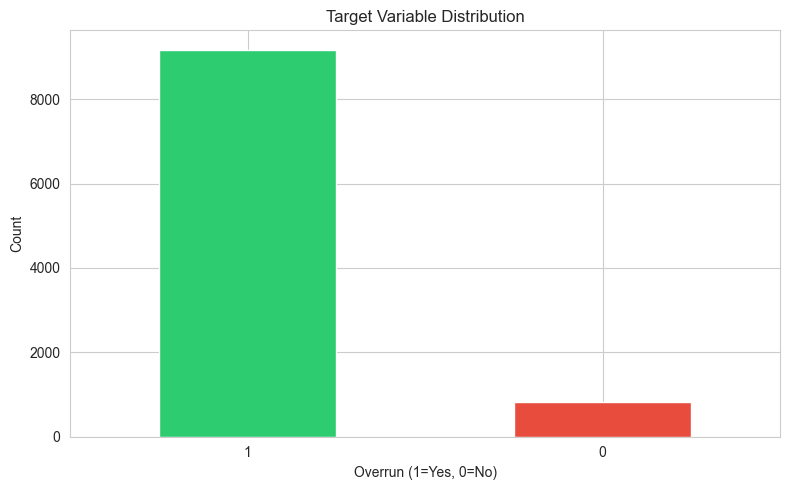

In [27]:
# Target variable distribution
print("Target variable distribution:")
print(df['label'].value_counts())
print(f"\nOverrun rate: {df['label'].mean()*100:.1f}%")

plt.figure(figsize=(8, 5))
df['label'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Target Variable Distribution')
plt.xlabel('Overrun (1=Yes, 0=No)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [28]:
# Feature columns (exclude metadata)
feature_cols = [col for col in df.columns if col not in [
    'project_id', 'label', 'budget_amount', 'actual_cost', 
    'start_date', 'end_date', 'actual_end_date'
]]

print(f"Number of features: {len(feature_cols)}")
print(f"\nFeatures: {feature_cols}")


Number of features: 14

Features: ['progress_pct', 'cpi', 'spi', 'vac_pct', 'burn_rate_ratio', 'overdue_pct', 'blocker_density', 'days_elapsed_pct', 'scope_creep_proxy', 'finance_gaps', 'invoice_lag_days', 'timesheet_volatility', 'avg_team_rate', 'people_active_7d']


In [29]:
# Feature statistics
print("Feature Statistics:")
df[feature_cols].describe()


Feature Statistics:


,progress_pct,cpi,spi,vac_pct,burn_rate_ratio,overdue_pct,blocker_density,days_elapsed_pct,scope_creep_proxy,finance_gaps,invoice_lag_days,timesheet_volatility,avg_team_rate,people_active_7d
count,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,63.679913,2.569163,0.632545,-2.558060e+04,2854.466172,29.749885,0.046296,93.054196,0.782503,180.707450,29.893509,10.152261,177.789899,22.965700
std,24.801220,35.230686,0.345851,4.444365e+05,4277.162090,13.680034,0.078452,17.362806,0.134006,843.424698,13.368416,4.931110,101.561758,73.152798
min,0.254066,0.100000,0.100000,-2.306725e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.888822,0.000000
25%,45.544942,0.100000,0.420520,-3.490354e+03,1498.409703,21.905116,0.000000,95.537087,0.733938,0.000000,22.862433,7.459527,114.745050,5.000000
50%,66.856638,0.100000,0.627544,-1.342208e+03,1728.025998,31.447231,0.023827,100.000000,0.795448,0.000000,31.142462,9.305797,160.849572,6.000000
75%,84.743550,0.184798,0.813591,-4.362615e+02,3960.102645,38.487575,0.057912,100.000000,0.852403,0.000000,38.370671,11.889873,238.541671,7.000000
max,100.000000,1921.838426,10.474754,1.147924e+02,133858.902748,100.000000,1.042833,100.000000,1.000000,16269.340116,66.227147,50.701923,1112.020985,1319.000000


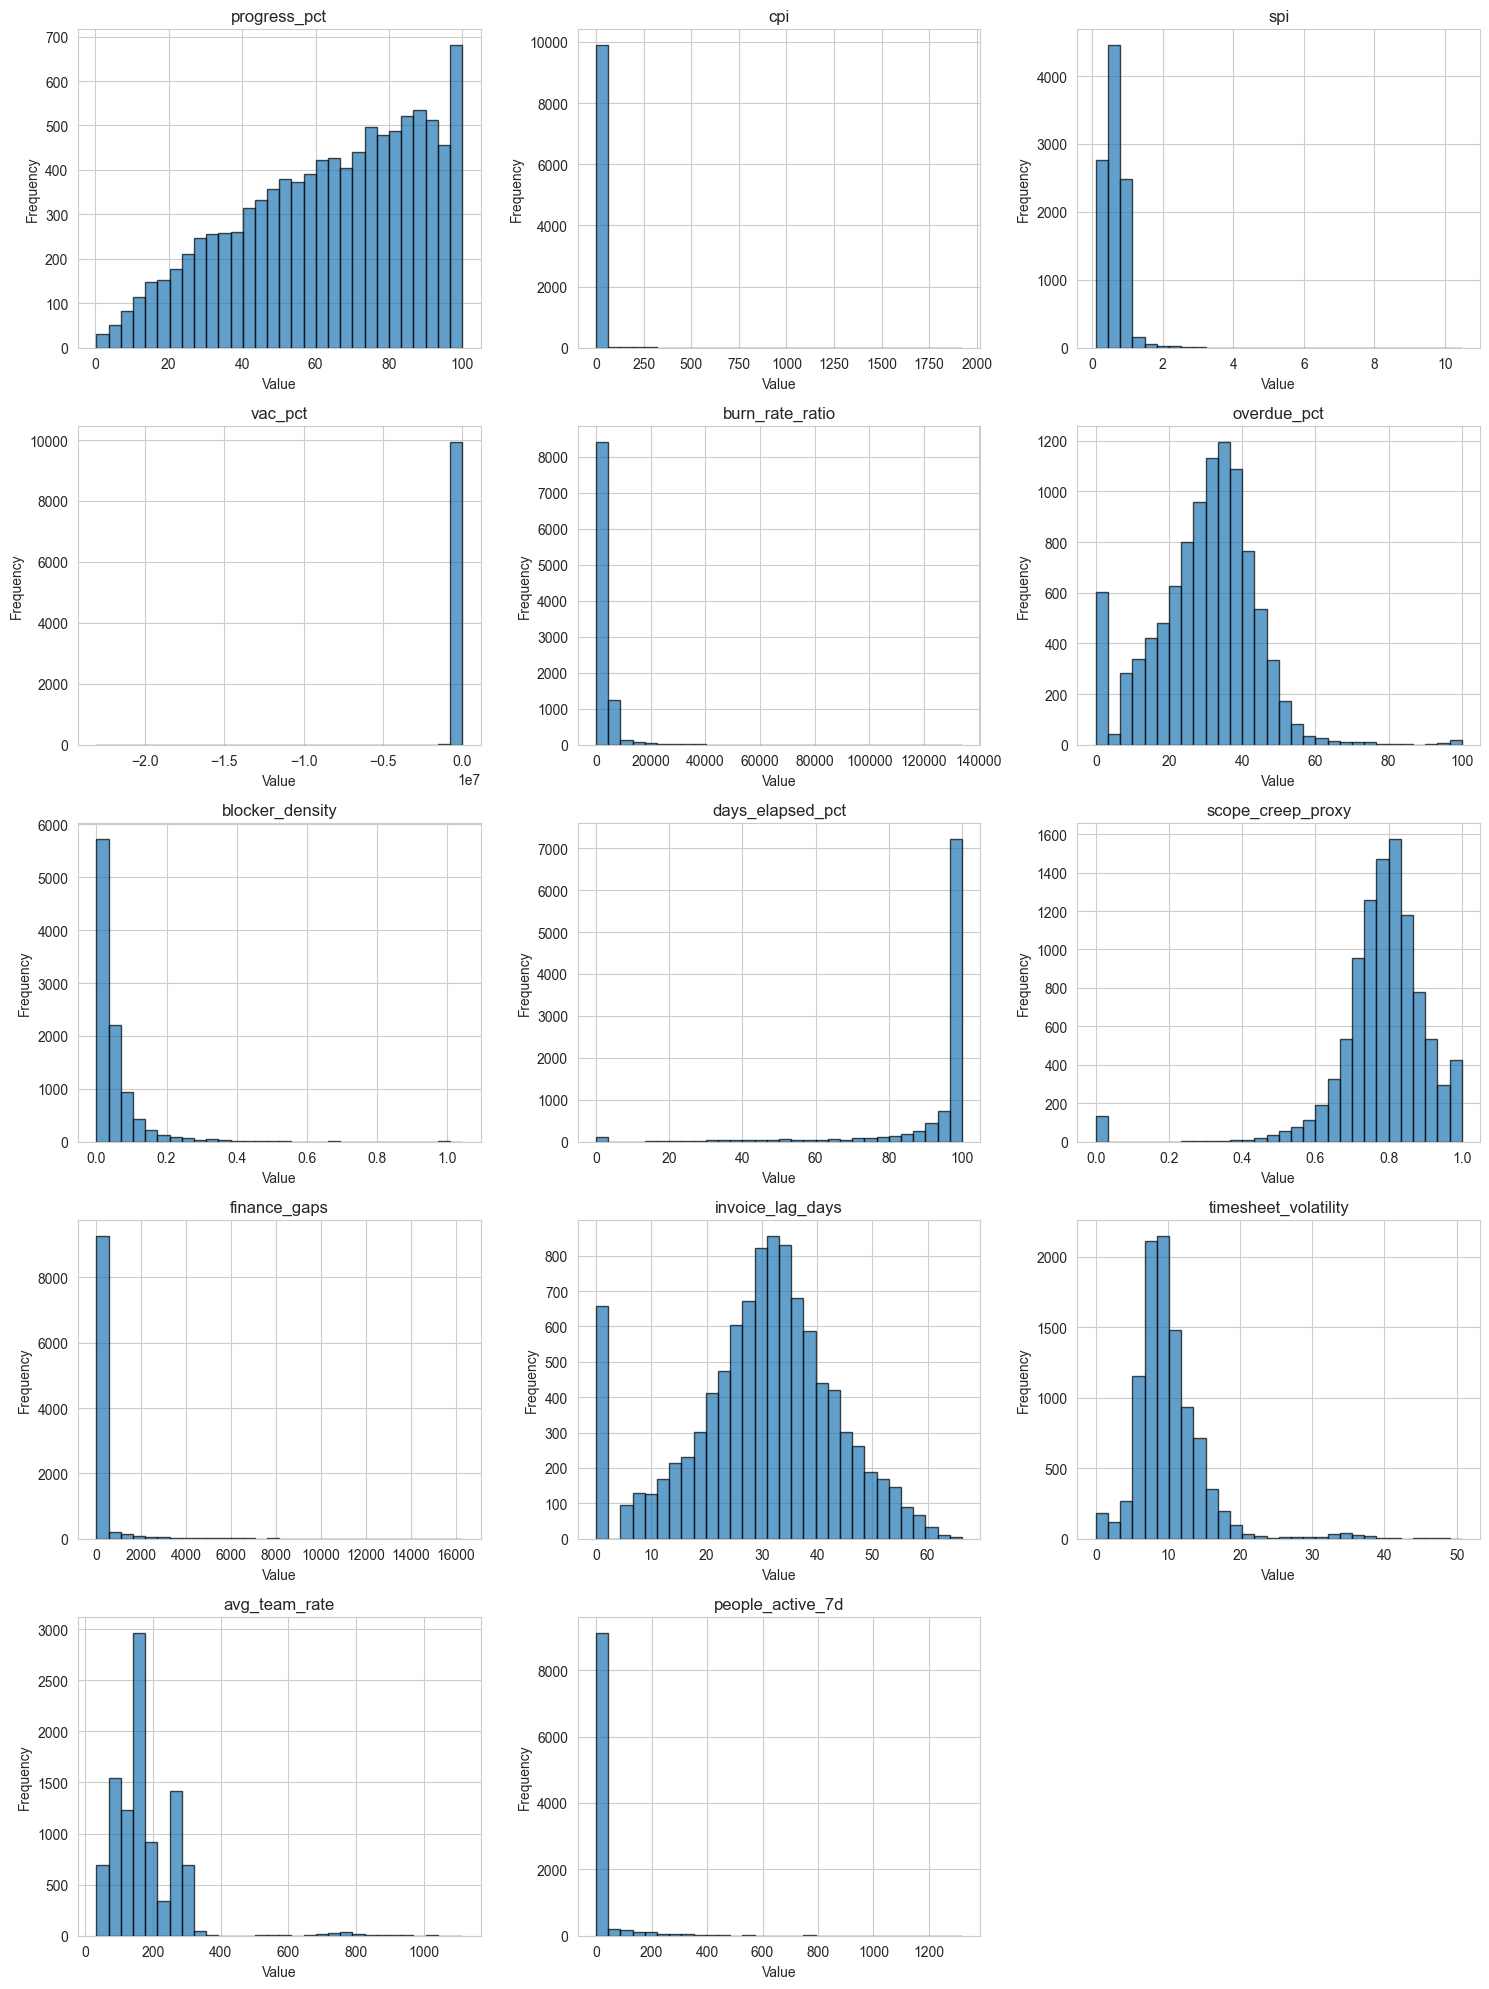

In [30]:
# Feature distributions
n_features = len(feature_cols)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide extra subplots
for i in range(n_features, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


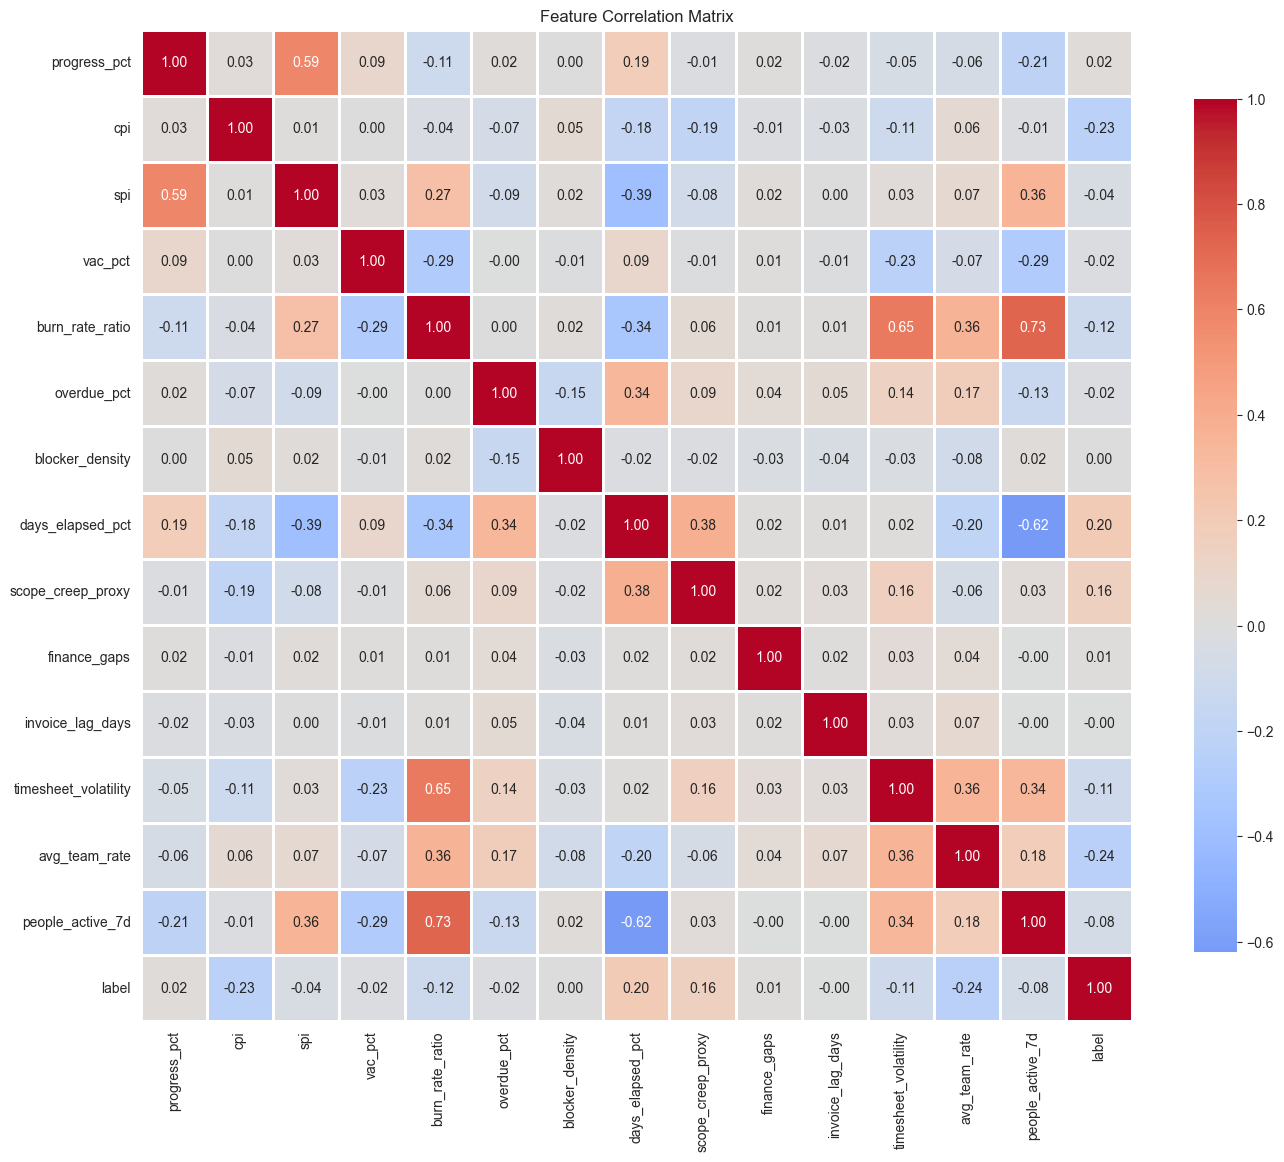

In [31]:
# Correlation matrix
correlation_matrix = df[feature_cols + ['label']].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


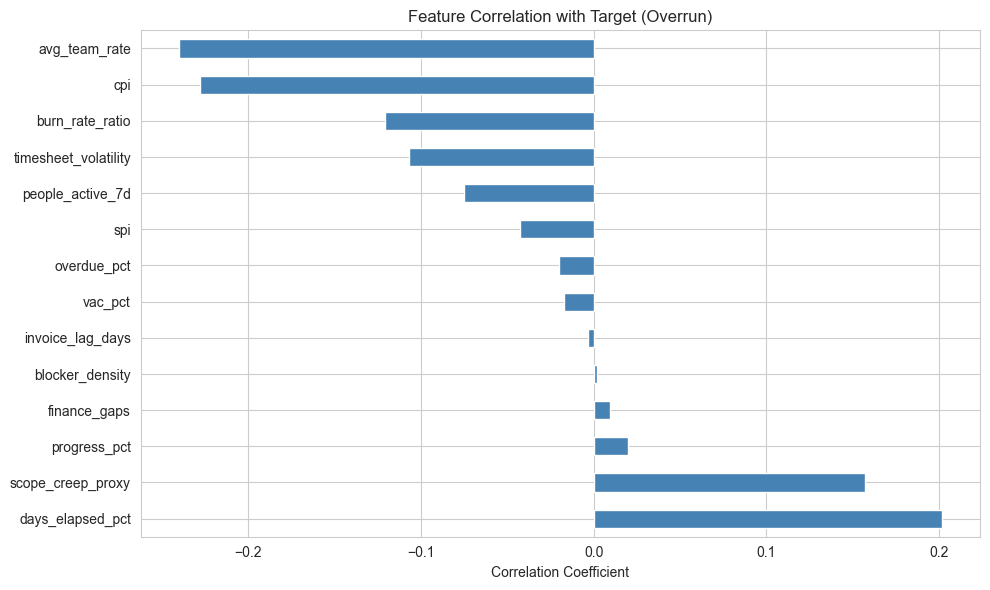


Top features correlated with overrun:
days_elapsed_pct     0.201613
scope_creep_proxy    0.156978
progress_pct         0.020022
finance_gaps         0.009583
blocker_density      0.001962
invoice_lag_days    -0.003451
vac_pct             -0.017294
overdue_pct         -0.020128
spi                 -0.042477
people_active_7d    -0.075289
Name: label, dtype: float64


In [32]:
# Feature correlation with target
target_corr = df[feature_cols + ['label']].corr()['label'].sort_values(ascending=False)
target_corr = target_corr.drop('label')

plt.figure(figsize=(10, 6))
target_corr.plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Target (Overrun)')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

print("\nTop features correlated with overrun:")
print(target_corr.head(10))


## 4. Data Preprocessing


In [33]:
# Prepare features and target
X = df[feature_cols].copy()
y = df['label'].copy()

# Handle missing values (fill with median for numeric features)
X = X.fillna(X.median())

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nMissing values after preprocessing: {X.isnull().sum().sum()}")


Features shape: (10000, 14)
Target shape: (10000,)

Missing values after preprocessing: 0


In [34]:
# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set overrun rate: {y_train.mean()*100:.1f}%")
print(f"Test set overrun rate: {y_test.mean()*100:.1f}%")


Training set: 8000 samples
Test set: 2000 samples

Training set overrun rate: 91.7%
Test set overrun rate: 91.7%


In [35]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully")


Features scaled successfully


## 5. Model Training - Logistic Regression


In [36]:
# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

print("Logistic Regression trained successfully")


Logistic Regression trained successfully


In [37]:
# Cross-validation
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")


Cross-validation ROC-AUC scores: [0.92011911 0.93077574 0.9553895  0.92282854 0.91335189]
Mean CV ROC-AUC: 0.9285 (+/- 0.0291)


## 6. Model Calibration


In [38]:
# Calibrate model using isotonic regression
calibrated_model = CalibratedClassifierCV(lr_model, method='isotonic', cv=5)
calibrated_model.fit(X_train_scaled, y_train)

print("Model calibrated successfully using isotonic regression")


Model calibrated successfully using isotonic regression


## 7. Model Evaluation


In [39]:
# Predictions
y_pred = calibrated_model.predict(X_test_scaled)
y_pred_proba = calibrated_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Model Performance Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")


Model Performance Metrics:
  Accuracy:  0.9485
  Precision: 0.9562
  Recall:    0.9891
  F1 Score:  0.9724
  ROC-AUC:   0.9257


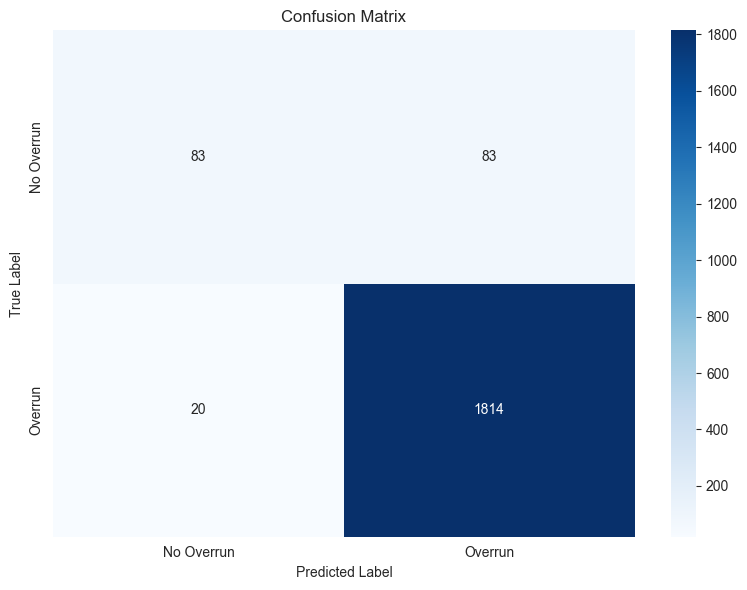

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Overrun', 'Overrun'],
            yticklabels=['No Overrun', 'Overrun'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [41]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Overrun', 'Overrun']))


Classification Report:
              precision    recall  f1-score   support

  No Overrun       0.81      0.50      0.62       166
     Overrun       0.96      0.99      0.97      1834

    accuracy                           0.95      2000
   macro avg       0.88      0.74      0.79      2000
weighted avg       0.94      0.95      0.94      2000



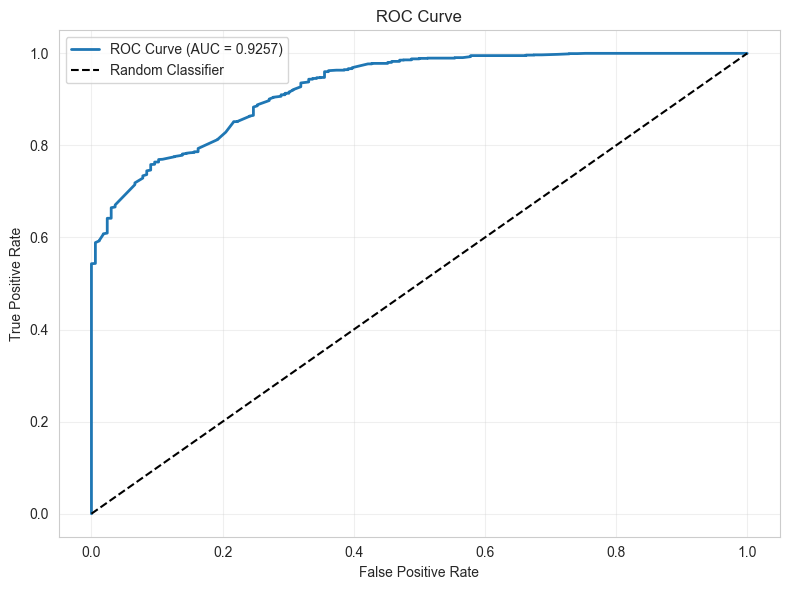

In [42]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Feature Importance


In [43]:
# Feature importance from Logistic Regression coefficients
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
})
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("Top Features by Importance (Logistic Regression Coefficients):")
print(feature_importance.to_string(index=False))


Top Features by Importance (Logistic Regression Coefficients):
             feature  coefficient  abs_coefficient
                 cpi   -28.138685        28.138685
             vac_pct    -8.959019         8.959019
       avg_team_rate    -0.442240         0.442240
    days_elapsed_pct     0.359988         0.359988
         overdue_pct    -0.312112         0.312112
        progress_pct     0.301964         0.301964
timesheet_volatility    -0.276190         0.276190
    people_active_7d     0.263999         0.263999
     burn_rate_ratio    -0.249943         0.249943
     blocker_density     0.139630         0.139630
   scope_creep_proxy     0.102692         0.102692
                 spi    -0.095322         0.095322
    invoice_lag_days    -0.015476         0.015476
        finance_gaps     0.009869         0.009869


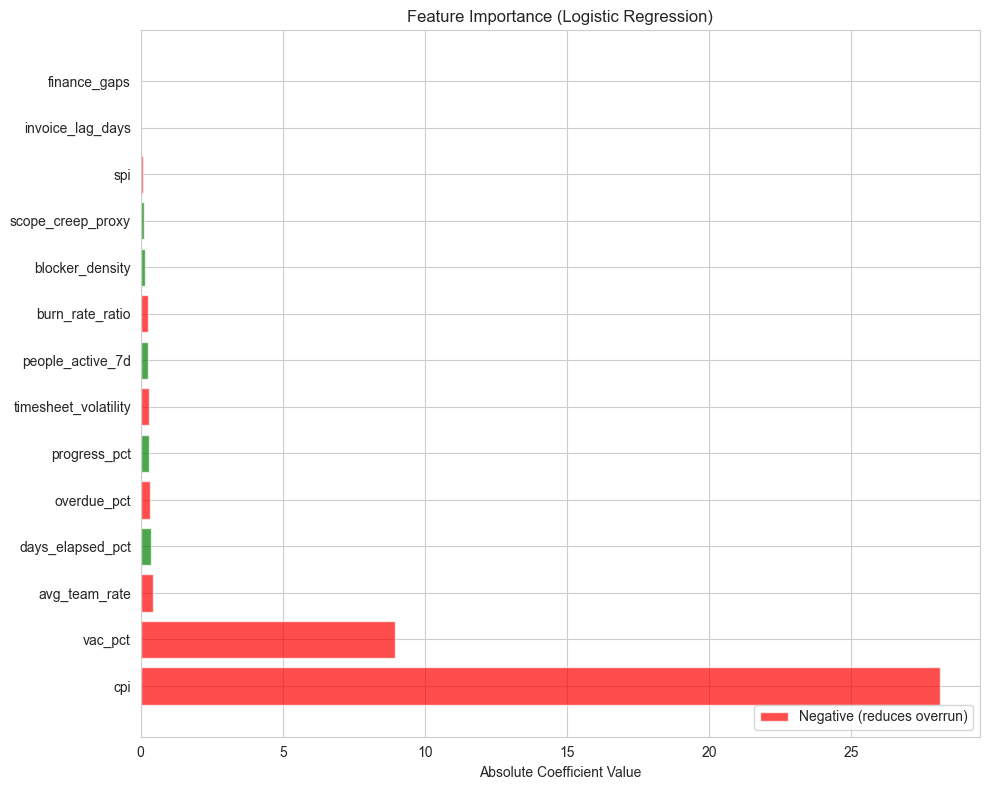


Top 5 drivers of overrun:
  + days_elapsed_pct: 0.3600
  + progress_pct: 0.3020
  + people_active_7d: 0.2640
  + blocker_density: 0.1396
  + scope_creep_proxy: 0.1027

Top 5 protectors against overrun:
  - cpi: -28.1387
  - vac_pct: -8.9590
  - avg_team_rate: -0.4422
  - overdue_pct: -0.3121
  - timesheet_volatility: -0.2762


In [44]:
# Visualize feature importance
plt.figure(figsize=(10, 8))
colors = ['red' if coef < 0 else 'green' for coef in feature_importance['coefficient']]
plt.barh(range(len(feature_importance)), feature_importance['abs_coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance (Logistic Regression)')
plt.legend(['Negative (reduces overrun)', 'Positive (increases overrun)'], loc='lower right')
plt.tight_layout()
plt.show()

print("\nTop 5 drivers of overrun:")
top_positive = feature_importance[feature_importance['coefficient'] > 0].head(5)
for _, row in top_positive.iterrows():
    print(f"  + {row['feature']}: {row['coefficient']:.4f}")

print("\nTop 5 protectors against overrun:")
top_negative = feature_importance[feature_importance['coefficient'] < 0].head(5)
for _, row in top_negative.iterrows():
    print(f"  - {row['feature']}: {row['coefficient']:.4f}")


## 9. Optional: XGBoost Model (for comparison)


In [45]:
try:
    import xgboost as xgb
    
    # Train XGBoost
    xgb_model = xgb.XGBClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])
    )
    xgb_model.fit(X_train_scaled, y_train)
    
    # Calibrate
    xgb_calibrated = CalibratedClassifierCV(xgb_model, method='isotonic', cv=5)
    xgb_calibrated.fit(X_train_scaled, y_train)
    
    # Evaluate
    xgb_pred = xgb_calibrated.predict(X_test_scaled)
    xgb_pred_proba = xgb_calibrated.predict_proba(X_test_scaled)[:, 1]
    xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)
    
    print(f"XGBoost ROC-AUC: {xgb_roc_auc:.4f}")
    print(f"Logistic Regression ROC-AUC: {roc_auc:.4f}")
    print(f"\nImprovement: {xgb_roc_auc - roc_auc:.4f}")
    
    # XGBoost feature importance
    xgb_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Features (XGBoost):")
    print(xgb_importance.head(10).to_string(index=False))
    
except ImportError:
    print("XGBoost not installed. Skipping XGBoost comparison.")
    print("Install with: pip install xgboost")


XGBoost ROC-AUC: 0.9998
Logistic Regression ROC-AUC: 0.9257

Improvement: 0.0741

Top 10 Features (XGBoost):
             feature  importance
                 cpi    0.811616
             vac_pct    0.070335
        progress_pct    0.065582
                 spi    0.007703
timesheet_volatility    0.007668
     burn_rate_ratio    0.007665
       avg_team_rate    0.007266
     blocker_density    0.006111
         overdue_pct    0.005844
    invoice_lag_days    0.003587


## 10. Model Persistence


In [46]:
import joblib

# Save model and scaler
joblib.dump(calibrated_model, 'project_overrun_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(feature_cols, 'feature_columns.pkl')

print("Model saved successfully:")
print("  - project_overrun_model.pkl")
print("  - feature_scaler.pkl")
print("  - feature_columns.pkl")


Model saved successfully:
  - project_overrun_model.pkl
  - feature_scaler.pkl
  - feature_columns.pkl


## 11. Summary

The model has been trained and evaluated. Key findings:

1. **Model Performance**: ROC-AUC score indicates model quality
2. **Feature Importance**: Top drivers identified from coefficients
3. **Calibration**: Model probabilities are well-calibrated for business use
4. **Model Saved**: Ready for deployment
